# First Look at incoming Hydroacoustics Data

In [1]:
# %pip install echopype

In [2]:
import echopype as ep

In [3]:
from pathlib import Path
import tqdm
import warnings
import xarray as xr

## Load a collection of war echo sounder outputs

In [4]:
def load_all_beams(directory=None, pattern=None):
    if pattern is None:
        pattern = "*.raw"
    all_raw_files = sorted(Path(directory).glob(pattern))
    datasets = [ep.open_raw(fn, sonar_model="EK80")["Sonar/Beam_group1"] for fn in tqdm.tqdm(all_raw_files)]
    return xr.concat(datasets, dim="ping_time")

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = load_all_beams("/home/jovyan/shared_data/incoming_mschaber/2024-02-19_MARDATA_AcousticData/", "CEMCV*raw")

100%|██████████| 8/8 [00:08<00:00,  1.11s/it]


## Have a look at the raw backscatter info

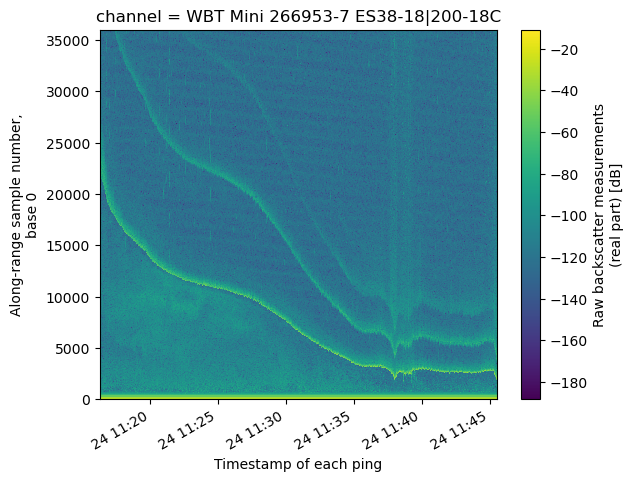

In [6]:
(
    ds.backscatter_r
    .isel(channel=0)
    .isel(ping_time=slice(None, None, 10), range_sample=slice(None, None, 50))
    .T.plot()
)

## Extract a single profile and add depth info

In [7]:
_bs = ds.isel(channel=0).isel(ping_time=-500).backscatter_r
_bs = _bs.assign_coords(z=(ds.range_sample * ds.sample_interval.isel(channel=0, ping_time=-500) * 1481 / 2))
_bs

<xarray.DataArray 'backscatter_r' (range_sample: 35952)>
array([ -16.344988,  -13.946156,   -7.443437, ..., -134.01714 ,
       -130.48944 , -127.73785 ], dtype=float32)
Coordinates:
    channel       <U33 'WBT Mini 266953-7 ES38-18|200-18C'
    ping_time     datetime64[ns] 2022-08-24T11:42:09.108850176
  * range_sample  (range_sample) int64 0 1 2 3 4 ... 35948 35949 35950 35951
    z             (range_sample) float64 0.0 0.005924 0.01185 ... 213.0 213.0
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

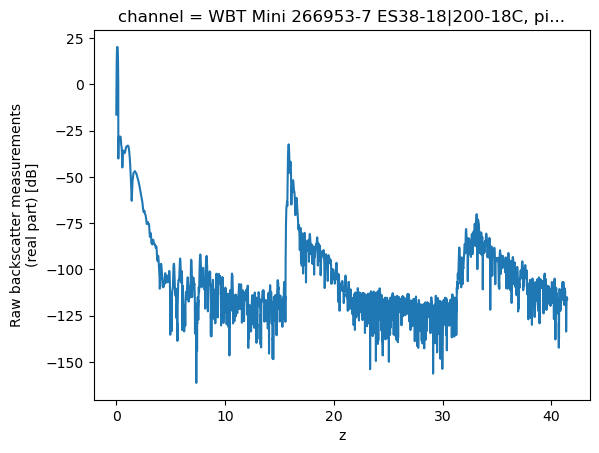

In [8]:
_bs.isel(range_sample=slice(0, 7000)).plot(x="z")

## Add depth info to whole dataset and plot upper-ocean backscatter with depth info

In [9]:
ds = ds.assign_coords(z=-(ds.range_sample * ds.sample_interval * 1481 / 2).mean("ping_time"))
ds

<xarray.Dataset>
Dimensions:                        (ping_time: 4352, channel: 2,
                                    range_sample: 35952)
Coordinates:
  * channel                        (channel) <U33 'WBT Mini 266953-7 ES38-18|...
  * ping_time                      (ping_time) datetime64[ns] 2022-08-24T11:1...
  * range_sample                   (range_sample) int64 0 1 2 ... 35950 35951
    z                              (range_sample, channel) float64 -0.0 ... -...
Data variables: (12/27)
    frequency_nominal              (ping_time, channel) float64 3.8e+04 ... 2...
    beam_type                      (ping_time, channel) int64 17 0 17 ... 0 17 0
    beamwidth_twoway_alongship     (ping_time, channel) float64 24.41 ... 17.3
    beamwidth_twoway_athwartship   (ping_time, channel) float64 30.06 ... 16.9
    beam_direction_x               (ping_time, channel) float64 nan nan ... nan
    beam_direction_y               (ping_time, channel) float64 nan nan ... nan
    ...                             ...
    transmit_power                 (channel, ping_time) float64 500.0 ... 250.0
    transmit_duration_nominal      (channel, ping_time) float32 0.000256 ... ...
    slope                          (channel, ping_time) float64 0.4112 ... 0....
    channel_mode                   (channel, ping_time) int8 0 0 0 0 ... 0 0 0 0
    transmit_type                  (channel, ping_time) <U3 'CW' 'CW' ... 'CW'
    sample_time_offset             (channel, ping_time) float64 0.0 0.0 ... 0.0
Attributes:
    beam_mode:              vertical
    conversion_equation_t:  type_3

In [10]:
bs_smoothed = (
    ds.backscatter_r
    .coarsen(ping_time=11, boundary="pad").max()
    .coarsen(range_sample=31, boundary="pad").max()
)
bs_smoothed

<xarray.DataArray 'backscatter_r' (channel: 2, ping_time: 396,
                                   range_sample: 1160)>
array([[[ 2.04371147e+01, -9.40718725e-02, -2.82803574e+01, ...,
         -1.13885757e+02, -1.12533478e+02, -1.10757874e+02],
        [ 2.04488735e+01,  1.18765736e+00, -2.82803574e+01, ...,
         -1.14144455e+02, -1.14967590e+02, -1.14638336e+02],
        [ 2.03783188e+01, -1.99902728e-01, -2.82803574e+01, ...,
         -1.13791687e+02, -1.15061661e+02, -1.16578568e+02],
        ...,
        [ 2.03195248e+01, -1.76384762e-01, -2.82568378e+01, ...,
         -1.07171379e+02, -1.06959717e+02, -1.06148346e+02],
        [ 2.04606323e+01,  1.22293437e+00, -2.82568378e+01, ...,
         -1.00762733e+02, -1.01585861e+02, -9.73291092e+01],
        [ 2.04253559e+01, -3.17492574e-01, -2.82450790e+01, ...,
         -1.04502090e+02, -1.07253693e+02, -1.06442322e+02]],

       [[ 1.67330341e+01, -6.51565323e+01, -8.10899506e+01, ...,
                     nan,             nan,             nan],
        [ 1.66272030e+01, -6.51565323e+01, -8.24187164e+01, ...,
                     nan,             nan,             nan],
        [ 1.66859989e+01, -6.49213486e+01, -7.59277573e+01, ...,
                     nan,             nan,             nan],
        ...,
        [ 1.64860954e+01, -6.05470085e+01, -8.79571991e+01, ...,
                     nan,             nan,             nan],
        [ 1.65448914e+01, -6.52388458e+01, -8.58170624e+01, ...,
                     nan,             nan,             nan],
        [ 1.67565517e+01, -6.24049301e+01, -8.82511749e+01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * channel       (channel) <U33 'WBT Mini 266953-7 ES38-18|200-18C' 'WBT Min...
  * ping_time     (ping_time) datetime64[ns] 2022-08-24T11:16:23.471750330 .....
  * range_sample  (range_sample) float64 15.0 46.0 77.0 ... 3.591e+04 3.594e+04
    z             (range_sample, channel) float64 -0.08886 -0.1333 ... -319.4
Attributes:
    long_name:  Raw backscatter measurements (real part)
    units:      dB

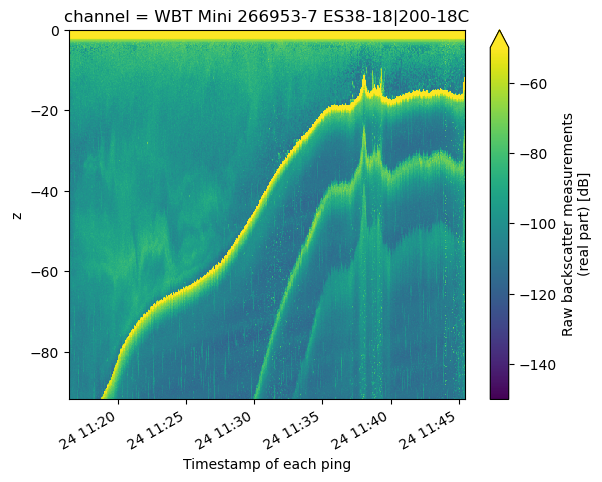

In [11]:
(bs_smoothed.isel(channel=0, range_sample=slice(0, 500))).plot(x="ping_time", y="z", vmax=-50, vmin=-150)

## Caveats

- This does not (yet) use any of the processing functionality provided by [echopype](https://echopype.readthedocs.io).

- The speed of sound is assumed to be 1481 m/s which is not correct for sea water especially with variable temperature and salinity.

- The vertical position of the echo sounder is not used.